In [48]:
import pathlib
import astropy.units as u
from synthesizAR.atomic.idl import read_spectral_table, write_spectral_table
import fiasco
import fiasco.io
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval, quantity_support

from mocksipipeline.util import read_cube_with_xarray

In [12]:
selected_elements = [
    'Fe',
    'Si',
    #'Mg',
    'Ne',
    'O',
]

In [33]:
def get_abundance_ratio(el_1, el_2):
    ratio_c = fiasco.Element(el_1,1*u.MK,abundance='sun_coronal_1992_feldman_ext').abundance / fiasco.Element(el_2,1*u.MK,abundance='sun_coronal_1992_feldman_ext').abundance
    ratio_p = fiasco.Element(el_1,1*u.MK,abundance='sun_photospheric_2015_scott').abundance / fiasco.Element(el_2,1*u.MK,abundance='sun_photospheric_2015_scott').abundance
    return ratio_c / ratio_p

print('R(Fe,Ne) = ', get_abundance_ratio('Fe','Ne'))
print('R(Si,O) = ', get_abundance_ratio('Si','O'))

R(Fe,Ne) =  3.019951720402013
R(Si,O) =  2.4547089156850235


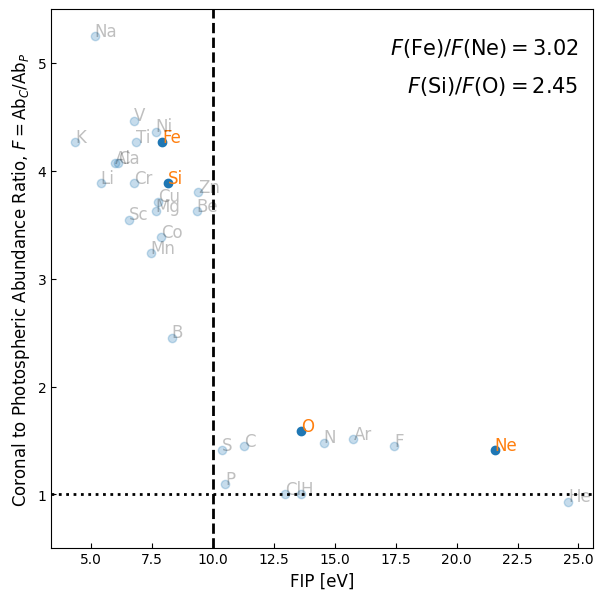

In [45]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
with quantity_support():
    elements = fiasco.list_elements()
    for el in elements:
        el_coronal = fiasco.Element(el, 1*u.MK, abundance='sun_coronal_1992_feldman_ext')
        el_photo = fiasco.Element(el, 1*u.MK, abundance='sun_photospheric_2015_scott')
        ax.plot(el_coronal[0].ip.to('eV'), el_coronal.abundance/el_photo.abundance,
                 marker='o',
                 ls='',
                 color='C0',
                 alpha=1 if el in selected_elements else 0.25)
        #if el in selected_elements:
        ax.annotate(el_coronal.atomic_symbol,
                     (el_coronal[0].ip.to_value('eV'), el_coronal.abundance/el_photo.abundance,),
                     fontsize=12,
                     color='C1' if el_coronal.atomic_symbol in selected_elements else 'k',
                     alpha=1 if el_coronal.atomic_symbol in selected_elements else 0.25,
                    )
    ax.axvline(x=10, ls='--', color='k')
    #ax.axhline(y=4, ls=':', color='k')
    ax.axhline(y=1, ls=':', color='k')
    ax.set_ylabel(r'Coronal to Photospheric Abundance Ratio, $F=\mathrm{Ab}_C/\mathrm{Ab}_P$')
    ax.set_xlabel('FIP [eV]')
    ax.set_ylim(0.5,5.5)
    ax.text(25,
            5.25,
            r'$F(\mathrm{Fe})/F(\mathrm{Ne})='+f"{get_abundance_ratio('Fe','Ne'):.02f}$",
            ha='right',
            va='top',
            fontsize=15)
    ax.text(25,
            4.9,
            r'$F(\mathrm{Si})/F(\mathrm{O})='+f"{get_abundance_ratio('Si','O'):.02f}$",
            ha='right',
            va='top',
            fontsize=15)
fig.savefig('rfa_figures/fip-ratio-plot.png', dpi=300)

## Contribution Functions

In [83]:
temperature = 10**np.arange(5.5,7.5,0.01)*u.K
ion_names = ['Ne X', 'Fe XVII', 'O VII', 'Si XII']
coronal_ions = fiasco.IonCollection(*[fiasco.Ion(name, temperature, abundance='sun_coronal_1992_feldman_ext') for name in ion_names])
photospheric_ions = fiasco.IonCollection(*[fiasco.Ion(name, temperature, abundance='sun_photospheric_2015_scott') for name in ion_names])

In [84]:
transitions = {
    'Ne 10': 12.1321*u.AA,
    'Fe 17': 15.0129*u.AA,
    'O 7': 21.601*u.AA,#18.967100143432617 * u.AA,
    'Si 12': 44.160301208496094*u.AA,
}

2024-09-30 17:22:50 - fiasco - WARNING: No proton data available for Ne 10. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:50 - fiasco - WARNING: No proton data available for Ne 10. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:50 - fiasco - WARNING: No proton data available for Fe 17. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:54 - fiasco - WARNING: No proton data available for Fe 17. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:59 - fiasco - WARNING: No proton data available for O 7. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:59 - fiasco - WARNING: No proton data available for O 7. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 17:22:59 - fiasco - WARNING: No p

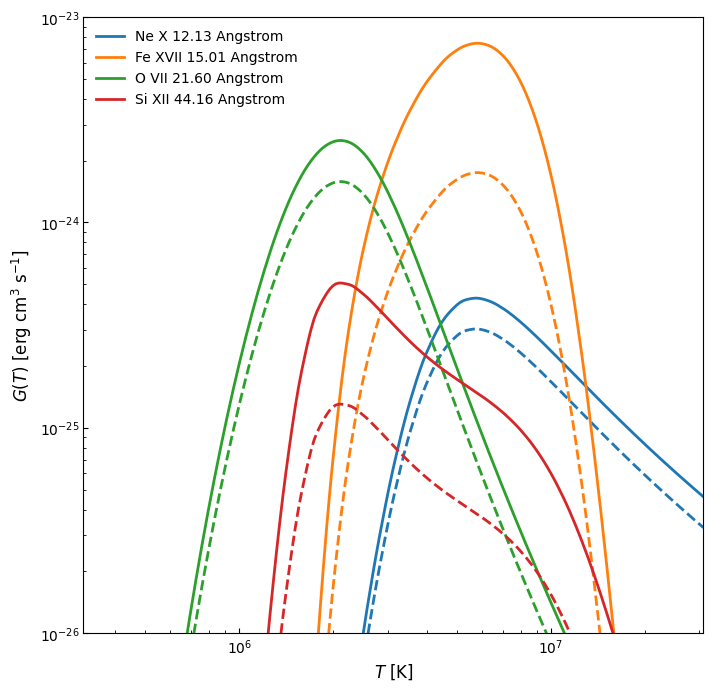

In [88]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
density = 1e9 * u.cm**(-3)
for i,ion in enumerate(coronal_ions):
    goft_c = ion.contribution_function(density).squeeze()
    wavelengths = ion.transitions.wavelength[~ion.transitions.is_twophoton]
    idx = np.argmin(np.fabs(wavelengths - transitions[ion.ion_name]))
    l, = ax.plot(ion.temperature, goft_c[:,idx], label=f'{ion.ion_name_roman} {wavelengths[idx]:.02f}')
    goft_p = photospheric_ions[i].contribution_function(density).squeeze()
    ax.plot(ion.temperature, goft_p[:,idx], color=l.get_color(), ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-23)
ax.set_xlim(ion.temperature[[0,-1]].value)
ax.set_xlabel(r'$T$ [K]')
ax.set_ylabel(r'$G(T)$ [erg cm$^{3}$ s$^{-1}$]')
ax.legend(frameon=False)
fig.savefig('rfa_figures/goft-line-plot.png',dpi=300)

Now show ratio of contribution functions as a function of temperature

2024-09-30 20:59:36 - fiasco - WARNING: No proton data available for Fe 17. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 20:59:41 - fiasco - WARNING: No proton data available for Ne 10. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 20:59:41 - fiasco - WARNING: No proton data available for Si 12. Not including proton excitation and de-excitation in level populations calculation.
2024-09-30 20:59:44 - fiasco - WARNING: No proton data available for O 7. Not including proton excitation and de-excitation in level populations calculation.
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


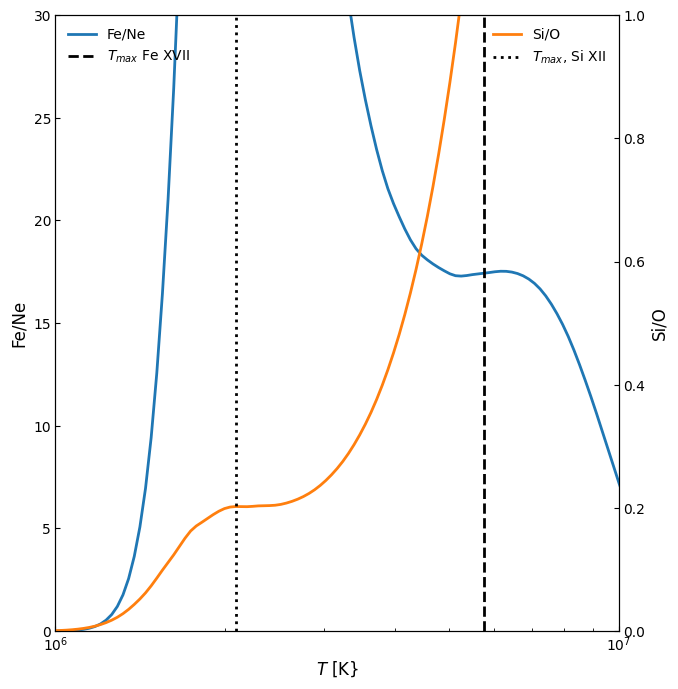

In [100]:
def get_goft_ratio(ion_1, ion_2):
    idx = np.argmin(np.fabs(ion_1.transitions.wavelength[~ion_1.transitions.is_twophoton] - transitions[ion_1.ion_name]))
    goft_1 = ion_1.contribution_function(density).squeeze()[:,idx]
    idx = np.argmin(np.fabs(ion_2.transitions.wavelength[~ion_2.transitions.is_twophoton] - transitions[ion_2.ion_name]))
    goft_2 = ion_2.contribution_function(density).squeeze()[:,idx]
    return goft_1, goft_2


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = ax1.twinx()#fig.add_subplot(122,sharex=ax1)

goft_fe,goft_ne = get_goft_ratio(coronal_ions[1], coronal_ions[0])
goft_si,goft_o = get_goft_ratio(coronal_ions[3], coronal_ions[2])

ax1.plot(temperature, goft_fe/goft_ne, label='Fe/Ne')
ax2.plot(temperature, goft_si/goft_o, label='Si/O',color='C1')
ax1.axvline(x=temperature[goft_fe.argmax()].value, color='k', ls='--', label=r'$T_{max}$ Fe XVII')
#ax1.axvline(x=temperature[goft_ne.argmax()].value, color='k', ls='--', label=r'$T_{max}$, Ne X')
ax2.axvline(x=temperature[goft_si.argmax()].value, color='k', ls=':', label=r'$T_{max}$, Si XII')
#ax2.axvline(x=temperature[goft_o.argmax()].value, color='k', ls='--', label=r'$T_{max}$, O VII')
ax1.set_xscale('log')
ax1.set_ylabel('Fe/Ne')
ax2.set_ylabel('Si/O')
ax1.set_xlabel(r'$T$ [K}')
ax1.set_ylim(0,30)
ax2.set_ylim(0,1)
ax1.set_xlim(1e6,1e7)
ax1.legend(loc=2)
ax2.legend(loc=1)
#ax.set_yscale('log')
fig.savefig('rfa_figures/goft-ratio-plot.png')

## Spectral Tables for Varying Abundances

The code below produces spectral tables per element for the different abundance models.

In [4]:
data_root = pathlib.Path('/Users/wtbarnes/Documents/codes/mocksipipeline/mocksipipeline/spectral/data/')

In [2]:
dbase_root = pathlib.Path('/Users/wtbarnes/Documents/projects/chianti/database/CHIANTI_v10.1.0/dbase/')
table_coronal = fiasco.io.Parser(dbase_root / 'abundance' / 'archive' / 'sun_coronal_1992_feldman_ext.abund').parse()
table_photospheric = fiasco.io.Parser(dbase_root / 'abundance' / 'sun_photospheric_2015_scott.abund').parse()

In [5]:
for element in selected_elements:
    spec_table_total = None
    ion_list = []
    for filename in sorted(data_root.glob(f'chianti-spectrum-{element.lower()}_*.asdf')):
        spec_table = read_spectral_table(filename)
        ion_list += spec_table.meta['ion_list']
        if spec_table_total is None:
            spec_table_total = spec_table
        else:
            spec_table_total = spec_table_total + spec_table.data * spec_table.unit
    for tab in [table_coronal, table_photospheric]:
        abund_name = tab.meta['filename'].name.split('.')[0]
        abundance = tab[tab['element']==element]['abundance']
        new_spec_table = spec_table_total * abundance
        abundance_filename = tab.meta['filename'].name
        new_spec_table.meta['abundance_filename'] = abundance_filename
        new_spec_table.meta['ion_list'] = ion_list
        new_filename = data_root / f'chianti-spectrum-{element.lower()}-{abundance_filename.split(".")[0]}.asdf'
        write_spectral_table(new_filename, new_spec_table)
        #plt.figure()
        #vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(new_spec_table.data)
        #new_spec_table.plot(aspect=100, norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()))
        #plt.title(new_filename.name)
        #plt.colorbar()
        #print(new_spec_table.meta)
        #plt.show()